In [1]:
import pandas as pd
import py0
import maxent
from py0 import MetaModel, traj_quantile, patch_quantile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
plt.style.use('seaborn-darkgrid')
# disabling gpu for now
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Set-up Model Parameters

In [2]:
# load mobility matrix
data = pd.read_csv('nys_commuting_counties.csv', index_col = 0).values
data = [i / np.sum(i) for i in data]
R = np.array(data)
M = R.shape[0]
np.sum(R, axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [3]:
# Make up some populations (take as known)
population = np.maximum(1000, np.round(np.random.normal(loc=100000, scale=25000, size=(M,)), 0))
area = np.maximum(250, np.round(np.random.normal(loc=2000, scale=1000, size=(M,)), 0))
print(area, population)


[1972. 1766.  928. 2711. 3435. 1758. 3173. 3689. 3201.  250.  644. 2865.
 2360. 1236. 2326. 2587. 2104. 2748. 3315. 1893. 3761. 2016. 3329. 1115.
 1874.  714. 2096. 3222.  250. 4477. 4085. 1906. 1561. 3757.  589. 3699.
 2212.  974. 2298. 1625. 2063. 2080.  716. 1940. 1988. 1291. 1015.  250.
  250. 3433. 2777. 3347. 1336. 3206.  885. 1807. 3158. 3405. 2084. 1181.
 1791. 2593.] [ 90620. 115818.  81869.  83620.  59699. 113204.  80733.  98669.  88363.
  80937.  87173.  62872.  94739. 114879.  69179.  89939.  76372.  94463.
 170507. 114754.  80778. 100985. 100230.  82333.  94536.  68670. 113834.
 146750.  56157.  88657.  55211. 117038. 121135.  84447. 118484. 112394.
 115725.  86634. 103624.  63340.  81694. 103346. 129934.  50006. 100633.
 114308. 141744. 106920. 142224. 125150.  64544. 102389. 138507. 118583.
 162024.  87854. 131522.  81949.  74592.  76212.  93503. 110807.]


In [4]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
infections_compartments = [1,2]
C = len(compartments)
tmat = py0.TransitionMatrix(compartments, [1,2])
tmat.add_transition('E', 'A', 5, 5)
tmat.add_transition('A', 'I', 3, 2)
tmat.add_transition('I', 'R', 14, 6)
print(tmat.value)
np.sum(tmat.value, axis=1)

[[0.8        0.2        0.         0.        ]
 [0.         0.66666667 0.33333333 0.        ]
 [0.         0.         0.92857143 0.07142857]
 [0.         0.         0.         1.        ]]


array([1., 1., 1., 1.])

In [5]:
# starting fractions probabilities
start = np.zeros((M,))  #anywhere
start[0] = 0.0001 # but likely 0

## Make starting joint

In [6]:
hyper_pram = py0.ParameterHypers()
hyper_pram.beta_low = [0.005]*2
hyper_pram.beta_high = [0.04]*2
hyper_pram.beta_var = [0.1]*2
param_model = py0.MetaParameterJoint(start, R, tmat, name='unbiased', n_infectious_compartments=2, hypers = hyper_pram)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


## Examine some of the statistics

In [7]:
v = param_model.sample(100)

/home/mgholiza/.conda/envs/covid-19/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


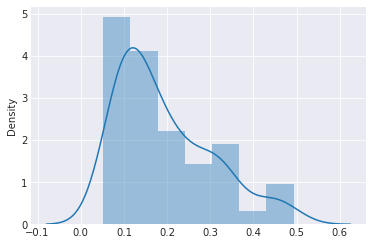

In [8]:
x = v[1][:,compartments.index('E'), compartments.index('A')].numpy()
sns.distplot(x=x)
plt.show()

In [9]:
np.mean(v[1][:, 0, 1]), 1/5

(0.19457349, 0.2)

In [10]:
# v[2][2]

In [11]:
# check transition matrix is valud
T = v[1][0].numpy()
print(T)
f = [0.1,0,0,0]
for i in range(1000):
    f = f @ T
    if i % 100 == 0:
        print(f, np.sum(f))

[[0.8689864  0.13101357 0.         0.        ]
 [0.         0.8448178  0.15518217 0.        ]
 [0.         0.         0.93720114 0.06279886]
 [0.         0.         0.         1.        ]]
[0.08689864 0.01310136 0.         0.        ] 0.1
[6.92328713e-08 3.53564880e-07 4.60288111e-04 9.95392795e-02] 0.09999999039767465
[5.51584042e-14 2.97972085e-13 7.03202961e-07 9.99992872e-02] 0.09999999039763412
[4.39451593e-20 2.38169639e-19 1.07241292e-09 9.99999893e-02] 0.09999999039763409
[3.50114738e-26 1.89788407e-25 1.63547144e-12 9.99999904e-02] 0.09999999039763419
[2.78939323e-32 1.51207743e-31 2.49415759e-15 9.99999904e-02] 0.09999999039763423
[2.22233278e-38 1.20468548e-37 3.80368739e-18 9.99999904e-02] 0.09999999039763419
[1.77055100e-44 9.59782981e-44 5.80077130e-21 9.99999904e-02] 0.09999999039763419
[1.41061271e-50 7.64667084e-50 8.84640199e-24 9.99999904e-02] 0.09999999039763419
[1.12384687e-56 6.09216624e-56 1.34911073e-26 9.99999904e-02] 0.09999999039763419



## Create set of trajectories
The loop is just to batch the trajectories. It is not necessary, just I have my at home GPU which has small RAM.
You could instead just pick `N = 16 * 256` and call once.

In [12]:
import tqdm
#tf.debugging.enable_check_numerics()
N = 256
batches = 4
total_batches = N*batches
outs = []
timesteps = 360
infect_fxn = py0.contact_infection_func(infections_compartments, area=area)
model = MetaModel(infect_fxn, timesteps, populations=population)
for b in tqdm.tqdm(range(batches)):
    psample = param_model.sample(N)
    outs.append(model(*psample))
trajs = np.concatenate(outs, axis=0)
print(trajs.shape)

100%|██████████| 4/4 [00:19<00:00,  4.96s/it]

(1024, 360, 62, 5)


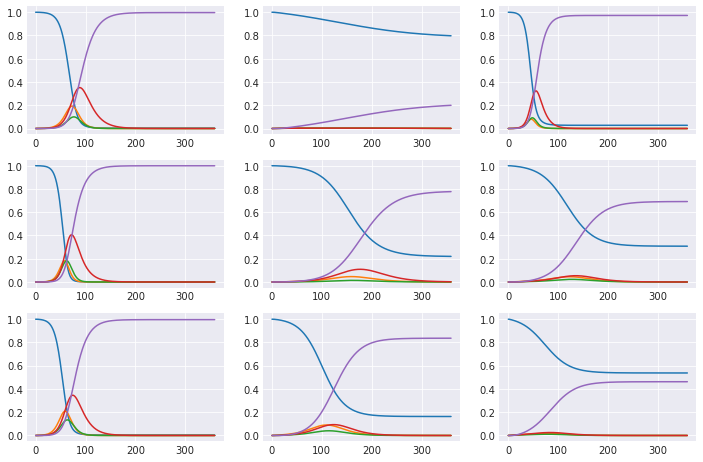

In [13]:
# plot a few trajectories
fig, ax = plt.subplots(3, 3, figsize=(12,8))
for i in range(3):
    for j in range(3):
        ax[i,j].plot(trajs[i * 3 + j,:,0,:])
plt.show()

## Make quantile Plots

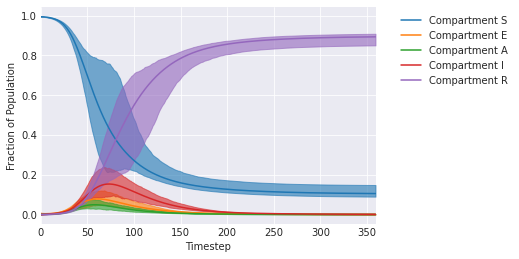

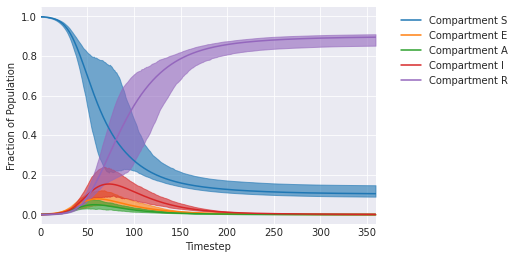

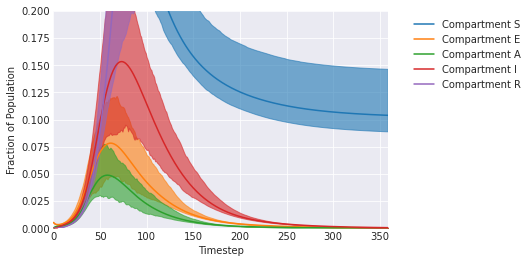

In [14]:
full_compartments = ['S'] + compartments
traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True)
plt.show()
traj_quantile(trajs[:,:,1,:], names=full_compartments, plot_means=True)
plt.show()
traj_quantile(trajs[:,:,2,:], names=full_compartments, plot_means=True)
plt.ylim(0,0.2)
plt.show()

## Create arbitrary restraints

In [15]:
restraints = np.array([
    [0.4, 0, 250, 0, 0],
    [0.12,0.05,200,2,1],
    [0.8, 0.1,300, 1, 4],
    [0.6, 0.1, 250, 34, 4],
    [0.4, 0.1, 250, 24, 0],
             ])
laplace_restraints = []
for i in range(len(restraints)):
    traj_index = tuple(restraints[i, 2:].astype(np.int))
    value = restraints[i, 0]
    uncertainty = restraints[i, 1]
    p = maxent.Laplace(uncertainty)
    #p = maxent.EmptyPrior()
    r = maxent.Restraint(lambda traj,j=traj_index: traj[j], value, p)
    laplace_restraints.append(r)

## Use maxent model to fit

In [16]:
model = maxent.MaxentModel(laplace_restraints)
model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')

In [17]:
history = model.fit(trajs, batch_size=total_batches, epochs=500, verbose=0)

In [18]:
model.summary()

Model: "maxent-model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reweight_layer_laplace (Rewe multiple                  5         
_________________________________________________________________
avg_layer_laplace (AvgLayerL multiple                  5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


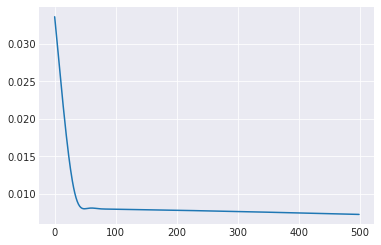

In [19]:
plt.plot(history.history['loss'])

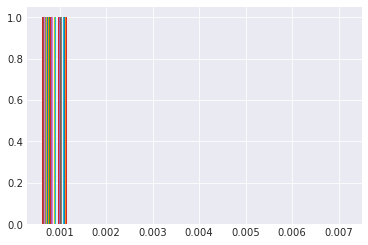

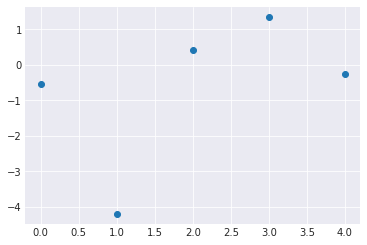

In [20]:
weights = model.traj_weights
plt.hist(weights)
plt.show()
plt.plot(model.lambdas.numpy(), 'o')

## Complete patch plots
disable if you want, they are very slow

Plotting 62 patches in a 7 x 9 grid


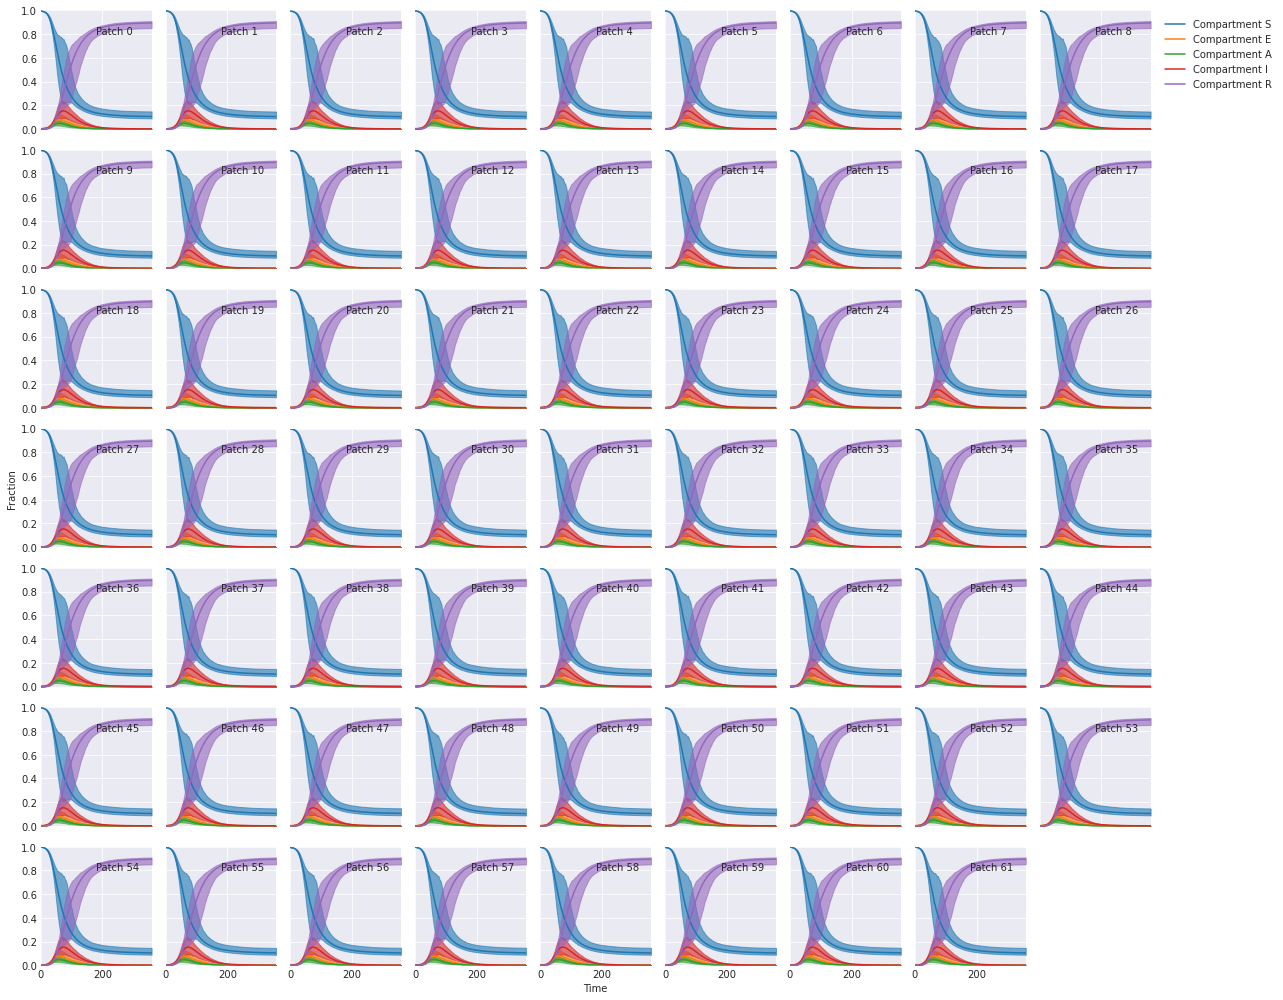

In [21]:
patch_quantile(trajs, figsize=(18, 14), alpha=0.6, names=['S', 'E', 'A', 'I', 'R'])
plt.show()

Plotting 62 patches in a 7 x 9 grid


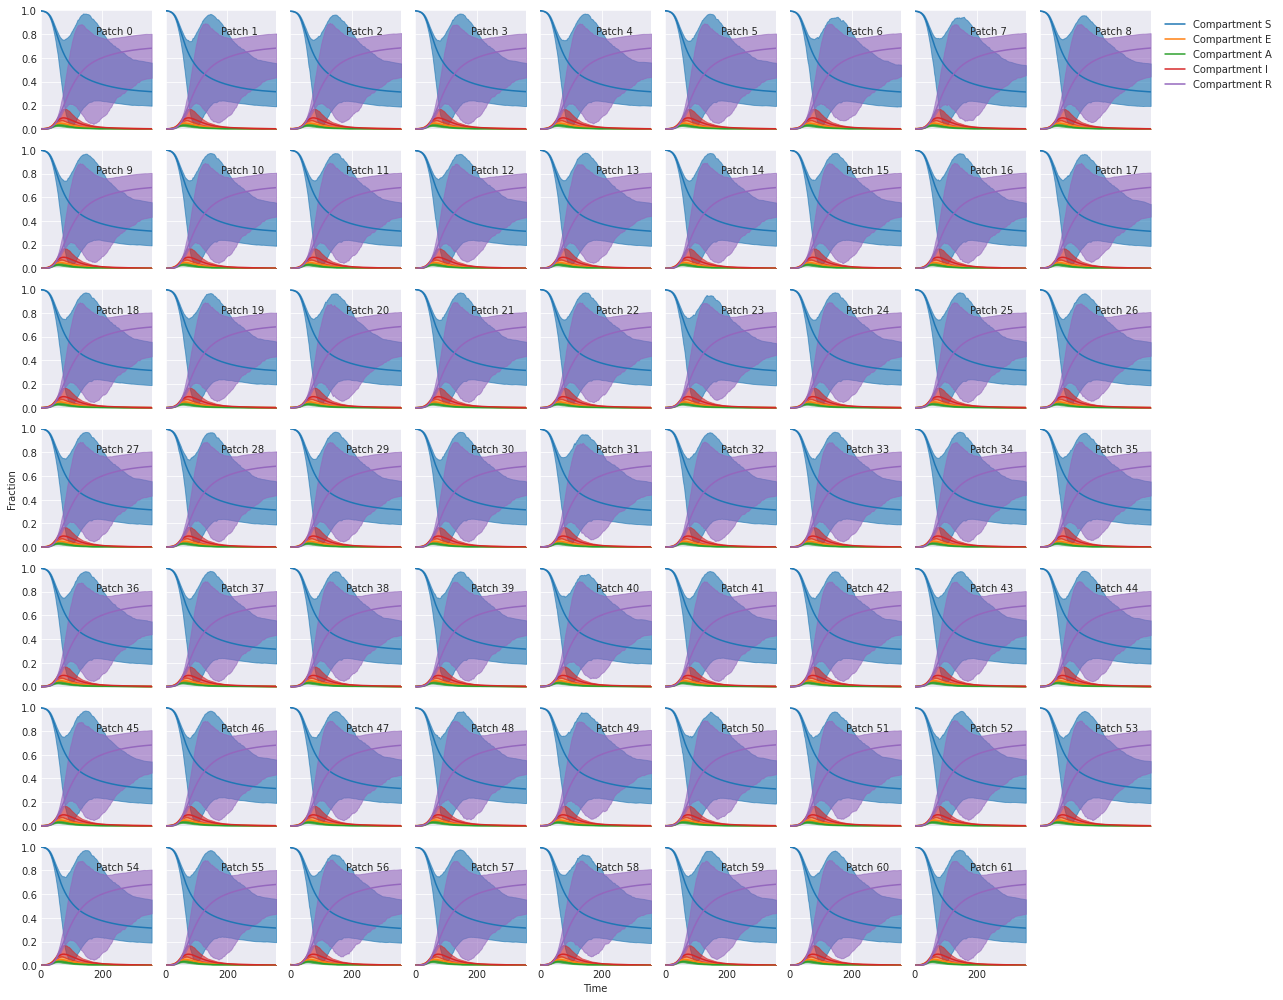

In [22]:
patch_quantile(trajs, weights=weights, figsize=(18, 14), alpha=0.6, names=['S', 'E', 'A', 'I', 'R'])
plt.show()

## Final plots showing agreement

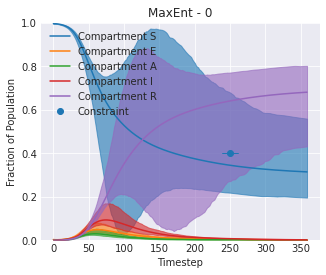

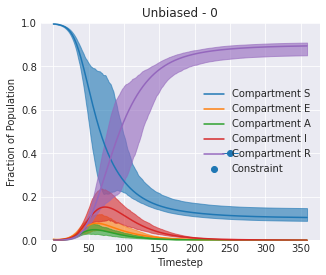

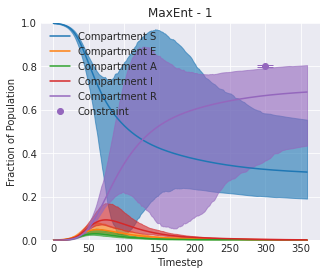

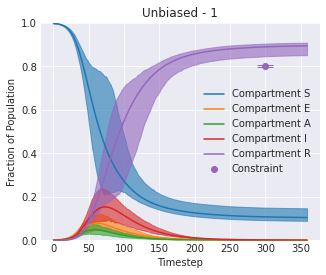

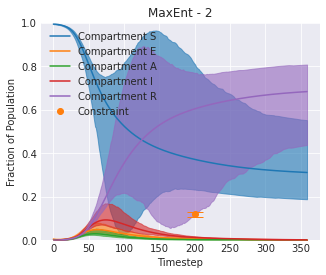

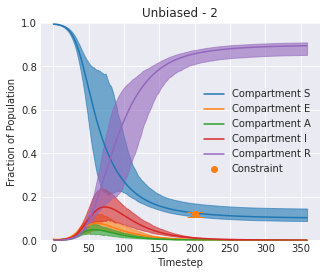

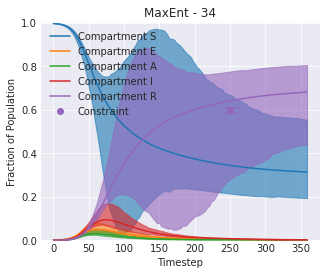

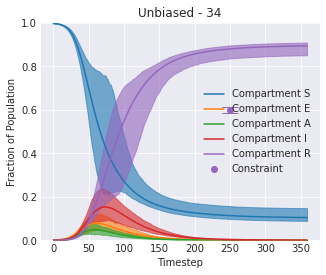

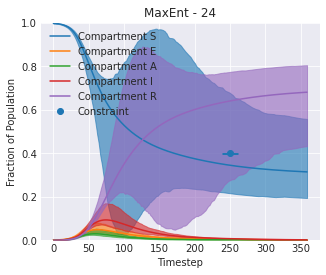

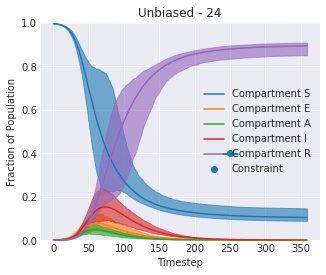

In [23]:
for p in [0,1,2,34,24]:
    plt.figure(figsize=(5,4))
    plt.title(f'MaxEnt - {p}')
    traj_quantile(trajs[:,:,p,:], weights, add_legend=False, names=['S', 'E', 'A', 'I', 'R'])
    for i, (pr, r) in enumerate(zip(laplace_restraints, restraints)):    
        if r[3] == p:
            plt.plot(r[2], r[0], 'o', color=f'C{int(r[-1])}', label='Constraint')
            plt.errorbar(r[2], r[0], yerr=pr.prior.expected(float(model.lambdas[i])), color=f'C{int(r[-1])}', capsize=8)
    plt.legend(loc='best')
    plt.ylim(0,1)
    plt.show()
    plt.figure(figsize=(5,4))
    plt.title(f'Unbiased - {p}')
    traj_quantile(trajs[:,:,p,:], add_legend=False, names=['S', 'E', 'A', 'I', 'R'])
    for i, (pr, r) in enumerate(zip(laplace_restraints, restraints)):    
        if r[3] == p:
            plt.plot(r[2], r[0], 'o', color=f'C{int(r[-1])}', label='Constraint')
            plt.errorbar(r[2], r[0], yerr=pr.prior.expected(float(model.lambdas[i])), color=f'C{int(r[-1])}', capsize=8)
    plt.legend(loc='best')
    plt.ylim(0,1)
    plt.show()